## Week 7 - Session 1: Compare RNNs

### Initialization

In [15]:
# Initialize modules
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
np.random.seed(13)
tf.random.set_seed(13)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Declare necessary functions
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def baseline(history):
  return np.mean(history)

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure(figsize=(6,4))

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

### Part 1: Prepare the dataset

In [2]:
# Load dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

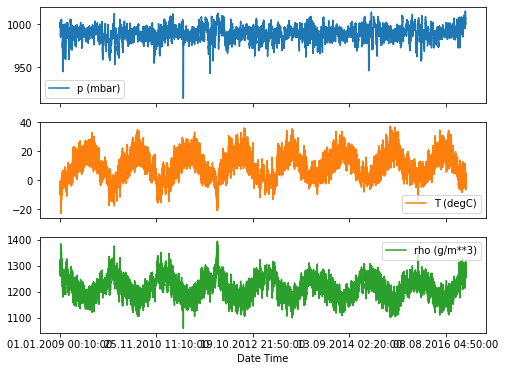

In [3]:
# Extract features
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']

# Plot features
features.plot(subplots=True)

* Atmospheric pressure, p (mbar), doesn't show any patterns from the plot and its value varies a little compared to other two features.
* Air temperature and air density show specific pattern (seasonality) and their values vary more.

In [4]:
# open session and initialize all variables

if True: # If you have multiple GPUs, you can set up how to use GPUs. Otherwise, set False
    os.environ['TF_CPP_MIN_LOG_LEVEL']='2'           # Ignore detailed log massages for GPU
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # the IDs match nvidia-smi
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'         # GPU-ID "0" or "0, 1" for multiple
    config = tf.compat.v1.ConfigProto()   
    config.gpu_options.per_process_gpu_memory_fraction = 0.2 
    #config.gpu_options.allow_growth = True 
    
    sess = tf.compat.v1.InteractiveSession(config=config)
else:  # If you do not have a GPU
    sess = tf.compat.v1.InteractiveSession()

In [5]:
# Initialize params
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10
past_history = 720
future_target = 72
STEP = 6

# Standardize the dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

# Prepare the dataset for the prediction task
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Part 2: Set-up and Train RNN-based Models

### RNN

In [6]:
# Set up the baseline model
rnn = tf.keras.models.Sequential()
rnn.add(tf.keras.layers.SimpleRNN(32, input_shape=x_train_single.shape[-2:]))
rnn.add(tf.keras.layers.Dense(1))

rnn.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [7]:
%%time
# Train RNN
rnn_history = rnn.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 16s 77ms/step - loss: 0.4148 - val_loss: 0.2904
Epoch 2/10
200/200 [==============================] - 15s 73ms/step - loss: 0.2968 - val_loss: 0.2610
Epoch 3/10
200/200 [==============================] - 15s 76ms/step - loss: 0.3070 - val_loss: 0.2702
Epoch 4/10
200/200 [==============================] - 15s 76ms/step - loss: 0.2915 - val_loss: 0.2598
Epoch 5/10
200/200 [==============================] - 15s 74ms/step - loss: 0.2468 - val_loss: 0.2470
Epoch 6/10
200/200 [==============================] - 15s 75ms/step - loss: 0.2643 - val_loss: 0.2530
Epoch 7/10
200/200 [==============================] - 15s 74ms/step - loss: 0.2638 - val_loss: 0.3142
Epoch 8/10
200/200 [==============================] - 14s 71ms/step - loss: 0.2674 - val_loss: 0.2512
Epoch 9/10
200/200 [==============================] - 14s 69ms/step - loss: 0.2781 - val_loss: 0.2444
Epoch 10/10
200/200 [==============================] - 14s 72ms/step - loss: 0.277

### LSTM

In [8]:
# Set up the LSTM model
lstm = tf.keras.models.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
lstm.add(tf.keras.layers.Dense(1))

lstm.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
# Train LSTM
lstm_history = lstm.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 11ms/step - loss: 0.3856 - val_loss: 0.2669
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2635 - val_loss: 0.2390
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2692 - val_loss: 0.2507
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2642 - val_loss: 0.2408
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2199 - val_loss: 0.2383
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2428 - val_loss: 0.2615
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2404 - val_loss: 0.2451
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2428 - val_loss: 0.2489
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2461 - val_loss: 0.2444
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2517 - val_loss: 0.228

### GRU

In [10]:
# Set up the GRU model
gru_model = tf.keras.models.Sequential()
gru_model.add(tf.keras.layers.GRU(32, input_shape=x_train_single.shape[-2:]))
gru_model.add(tf.keras.layers.Dense(1))

gru_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3552      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


In [11]:
%%time
# Train GRU
gru_history = gru_model.fit(train_data_single, epochs=EPOCHS,
                            steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data_single,
                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 10ms/step - loss: 0.4161 - val_loss: 0.2503
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2766 - val_loss: 0.2404
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2733 - val_loss: 0.2383
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2724 - val_loss: 0.2389
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2222 - val_loss: 0.2318
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2497 - val_loss: 0.2490
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2493 - val_loss: 0.2463
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2461 - val_loss: 0.2468
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2578 - val_loss: 0.2405
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2625 - val_loss: 

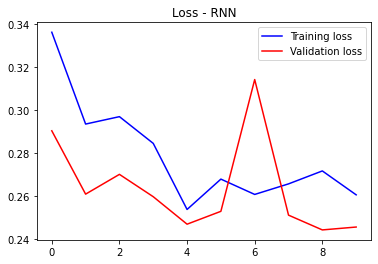

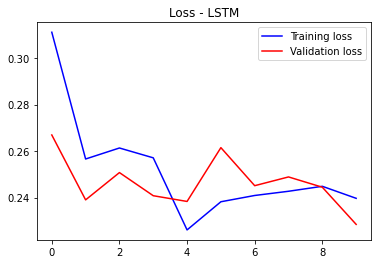

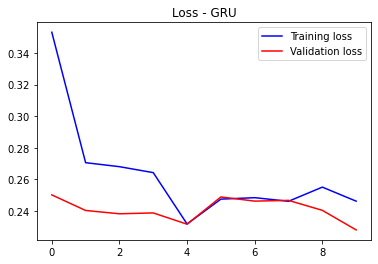

In [16]:
# Plot losses for LSTM/GRU model
plot_train_history(rnn_history, 'Loss - RNN')
plot_train_history(lstm_history, 'Loss - LSTM')
plot_train_history(gru_history, 'Loss - GRU')

In [18]:
# Compare the MAEs: LSTM vs GRU
rnn_loss = rnn.evaluate(val_data_single, steps=50, verbose=0) 
lstm_loss = lstm.evaluate(val_data_single, steps=50, verbose=0) 
gru_loss = gru_model.evaluate(val_data_single, steps=50, verbose=0) 

print("RNN: {:.4f} vs. LSTM: {:.4f} vs. GRU: {:.4f}".format(rnn_loss, lstm_loss, gru_loss))

RNN: 0.2457 vs. LSTM: 0.2285 vs. GRU: 0.2281


### Part 3: Tuning the Model

In [20]:
%%time
tune_histories = []
tune_losses = []

# Initialize params
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10
past_histories = [720, 500, 150]  # length of past history 
future_target = 72
STEP = 6

for past_history in past_histories:
  # Prepare the dataset for the prediction task
    x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                    TRAIN_SPLIT, past_history,
                                                    future_target, STEP,
                                                    single_step=True)
    x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                                TRAIN_SPLIT, None, past_history,
                                                future_target, STEP,
                                                single_step=True)

    train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
    train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
    val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

    # Set up the GRU model
    gru_tune = tf.keras.models.Sequential()
    gru_tune.add(tf.keras.layers.GRU(32, input_shape=x_train_single.shape[-2:]))
    gru_tune.add(tf.keras.layers.Dense(1))

    gru_tune.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

    # Train the model
    print("Training a model with {} past history >>".format(past_history))
    gru_tune_history = gru_tune.fit(train_data_single, epochs=EPOCHS,
                              steps_per_epoch=EVALUATION_INTERVAL,
                              validation_data=val_data_single,
                              validation_steps=50, verbose=0)
  
    tune_histories.append(gru_tune_history)
    tune_losses.append(gru_tune.evaluate(val_data_single, steps=50, verbose=0))

print("Done!")

Training a model with 720 past history >>
Training a model with 500 past history >>
Training a model with 150 past history >>
Done!
CPU times: user 1min 31s, sys: 9.76 s, total: 1min 41s
Wall time: 1min 19s


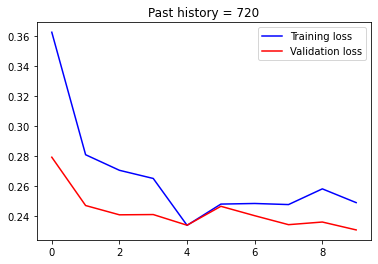

>> Test loss(MAE) = 0.23069851100444794



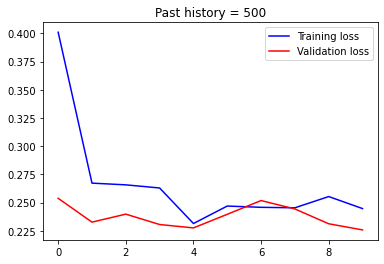

>> Test loss(MAE) = 0.22577957808971405



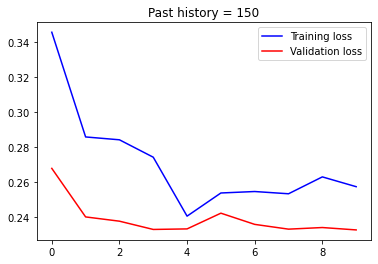

>> Test loss(MAE) = 0.2328530102968216



In [21]:
for idx, hist in enumerate(tune_histories):
  plot_train_history(hist, 'Past history = {}'.format(past_histories[idx]))
  print(">> Test loss(MAE) = {}\n".format(tune_losses[idx]))

## After running the above code, think about or implement the following:
1. Compare and contrast the different models presented above.
2. Try passing some other "features considered" into the model and see how it performs.